In [1]:
n_gen = 2  # number of generators
latent_dim = 256  # dimention of input noise
batch_size = 256  # number of batches
size_dataset = 60_000  # size MNIST dataset - 60_000
epochs = 2
steps_per_epoch = (size_dataset // batch_size) // n_gen
type = "no-stack"

import datetime

current_date = datetime.datetime.now().strftime("%Y-%m-%d")

dir_name = f"models/MNIST_{n_gen}-gen_{epochs}-ep_{type}-type_{current_date}"  # location to save the model

In [2]:
import os

# Check if the folder exists, if not, create it
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
    print(f"Folder created at: {dir_name}")
else:
    print(f"Folder already exists at: {dir_name}")

Folder already exists at: models/MNIST_2-gen_2-ep_no-stack-type_2024-12-05


# Adding Libraries

In [3]:
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import (
    Input,
    Dense,
    Dropout,
    LeakyReLU,
    Conv2D,
    Conv2DTranspose,
    Flatten,
    Reshape,
    BatchNormalization,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import Model


import numpy as np

In [4]:
# for saving GIF

print("Import Done")

Import Done


# To see if we have a GPU

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

if tf.test.gpu_device_name() == "/device:GPU:0":
    print("Using a GPU")
else:
    print("Using a CPU")

Num GPUs Available:  1
Using a GPU


In [6]:
print(f"GPUs available: {tf.config.list_physical_devices('GPU')}")

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Aquire dataset MNIST
## generate latent samples

In [7]:
(train_images, train_labels), (test_images, test_labels) = (
    tf.keras.datasets.mnist.load_data()
)

In [8]:
print("Shape of data")
train_images[0].shape

Shape of data


(28, 28)

In [9]:
from tensorflow_probability import distributions as tfd


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, batch_size, n_gen):
    # Multivariate normal diagonal distribution
    mvn = tfd.MultivariateNormalDiag(
        loc=[0] * latent_dim, scale_diag=[1.0] * latent_dim
    )

    noise = []
    for i in range(n_gen):
        # Some samples from MVN
        x_input = mvn.sample(batch_size)
        noise.append(x_input)
    return noise

# generator related
## monitor, loss
## plotting funcitons

In [10]:
from PIL import Image
import os


# Function to create a GIF from a list of image paths
def create_gif(image_folder, output_gif, duration=500):
    image_files = sorted(
        [
            os.path.join(image_folder, file)
            for file in os.listdir(image_folder)
            if file.endswith(".png")
        ]
    )

    frames = []
    for image_name in image_files:
        img = Image.open(image_name)
        frames.append(img)

    # Save the frames as an animated GIF
    frames[0].save(
        output_gif,
        format="GIF",
        append_images=frames[1:],
        save_all=True,
        duration=duration,
        loop=0,
    )

In [11]:
def plot_training_history(history, save: bool = True):
    # Extract losses from history
    history_dict = history.history
    generator_losses = []
    discriminator_loss = None

    # Separate generator losses and discriminator loss
    for key in history_dict.keys():
        if "g_loss" in key:
            generator_losses.append((key, history_dict[key]))
        elif key == "d_loss":
            discriminator_loss = history_dict[key]

    # Plotting
    plt.figure(figsize=(10, 6))

    # Plot generator losses
    for gen_loss_key, gen_loss_values in generator_losses:
        plt.plot(gen_loss_values, label=gen_loss_key)

    # Plot discriminator loss
    if discriminator_loss is not None:
        plt.plot(
            discriminator_loss,
            label="d_loss",
            linewidth=2,
            linestyle="--",
            color="black",
        )

    plt.title("Training Losses")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Display the plot
    plt.show()
    if save:
        plt.savefig(
            f"{dir_name}/image_at_epoch_{(epoch + 1):04}.png", dpi=200, format="png"
        )


def plot_generators_examples(
    n_rows: int,
    n_cols: int,
    random_latent_vectors: list,
    data,
    generators: list,
    dir_name: str,
    epoch: int,
    save: bool = False,
    show: bool = True,
) -> None:
    # Create a figure and a grid of subplots
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 8))
    fig.suptitle(f"Epoch: {epoch}", fontsize=20)
    # Flatten the axes array to iterate over individual subplots
    axes = axes.flatten()

    # Iterate over the subplots
    for i, ax in enumerate(axes):
        # Calculate the current row based on index
        current_row = i // n_cols

        # Determine if we're plotting real or generated data
        if (i + 1) % n_cols == 0:
            # Plot real data
            if current_row < len(data):
                ax.imshow(
                    (
                        data[
                            current_row,
                            :,
                            :,
                        ]
                        * 127.5
                        + 127.5
                    )
                    / 255,
                    cmap="gray",
                )
                ax.set_title("REAL")
            else:
                print(
                    f"Skipping real data plot for row {current_row}: Index out of bounds."
                )
        else:
            # Plot generated data
            generator_index = i % (n_cols - 1)
            generated_sample = generators[generator_index](
                random_latent_vectors[generator_index]
            )
            ax.imshow(
                (
                    generated_sample[
                        current_row,
                        :,
                        :,
                    ]
                    * 127.5
                    + 127.5
                )
                / 255,
                cmap="gray",
            )
            ax.set_title(f"FAKE (Gen {generator_index + 1})")

        # Turn off axis labels for clarity
        ax.axis("off")

    # Adjust layout and spacing
    fig.tight_layout()

    if save:
        plt.savefig(
            f"{dir_name}/image_at_epoch_{(epoch + 1):04}.png", dpi=200, format="png"
        )
    if show:
        plt.show()

##### Loss function for the generators based on the MAD_GAN paper

In [12]:
def Generators_loss_function(y_true, y_pred):
    logarithm = -tf.math.log(y_pred[:, -1] + 1e-15)
    return tf.reduce_mean(logarithm, axis=-1)

In [13]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(
        self,
        random_latent_vectors,
        data,
        n_classes,
        latent_dim=128,
        dir_name="Model",
        generate_after_epochs: int = 10,
    ):
        self.data = data[0:10]
        self.random_latent_vectors = random_latent_vectors
        self.latent_dim = latent_dim
        self.dir_name = dir_name
        self.n_classes = n_classes
        self.generate_after_epochs = generate_after_epochs

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.generate_after_epochs == 0:
            plot_generators_examples(
                n_rows=len(self.model.generators),
                n_cols=len(self.model.generators) + 1,
                dir_name=self.dir_name,
                random_latent_vectors=self.random_latent_vectors,
                data=self.data,
                generators=self.model.generators,
                epoch=epoch,
                save=True,
            )

# define Discriminator 


In [14]:
# define the standalone discriminator model
def define_discriminator(n_gen):
    inp = Input(shape=(28, 28, 1))

    x = Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=[28, 28, 1])(inp)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (5, 5), strides=(2, 2), padding="same")(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    out = Dense(n_gen + 1, activation="softmax")(x)

    model = Model(inp, out, name="Discriminator")
    return model

# define Generators

In [15]:
7 * 7 * 256

12544

In [16]:
def define_generators(n_gen, latent_dim, class_labels):
    dens = Dense(units=7 * 7 * 256, use_bias=False, input_shape=(latent_dim,))
    batchnorm0 = BatchNormalization()
    rel0 = LeakyReLU()
    reshape0 = Reshape([7, 7, latent_dim])

    con2dt1 = Conv2DTranspose(
        128, (5, 5), strides=(1, 1), padding="same", use_bias=False
    )
    batchnorm1 = BatchNormalization()
    rel1 = LeakyReLU()

    con2dt2 = Conv2DTranspose(
        64, (5, 5), strides=(2, 2), padding="same", use_bias=False
    )
    batchnorm2 = BatchNormalization()
    rel2 = LeakyReLU()

    models = []
    for label in range(n_gen):
        input = Input(shape=(latent_dim,), dtype=tf.float64, name=f"input_{label}")
        x = dens(input)
        x = batchnorm0(x)
        x = rel0(x)
        x = reshape0(x)

        x = con2dt1(x)
        x = batchnorm1(x)
        x = rel1(x)

        x = con2dt2(x)
        x = batchnorm2(x)
        x = rel2(x)

        x = Conv2DTranspose(
            1, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh"
        )(x)

        models.append(Model(input, x, name=f"generator{label}"))
    return models

# defining the N-MAD GAN

In [17]:
class MADGAN(tf.keras.Model):
    def __init__(self, discriminator, generators, latent_dim, n_gen):
        super(MADGAN, self).__init__()
        self.discriminator = discriminator
        self.generators = generators
        self.latent_dim = latent_dim
        self.n_gen = n_gen

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(MADGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def train_step(self, data):
        X = data

        batch_size = tf.shape(X)[0]
        random_latent_vectors = generate_latent_points(
            self.latent_dim, batch_size // self.n_gen, self.n_gen
        )
        print(self.latent_dim, batch_size // self.n_gen, self.n_gen)
        # Decode them to fake generator output
        x_generator = []
        for g in range(self.n_gen):
            x_generator.append(self.generators[g](random_latent_vectors[g]))

        # Combine them with real samples
        combined_samples = tf.concat(
            [x_generator[g] for g in range(self.n_gen)] + [X], axis=0
        )
        # Assemble labels discriminating real from fake samples
        labels = tf.concat(
            [
                tf.one_hot(
                    g * tf.ones(batch_size // self.n_gen, dtype=tf.int32),
                    self.n_gen + 1,
                )
                for g in range(self.n_gen)
            ]
            + [
                tf.one_hot(
                    self.n_gen * tf.ones(batch_size, dtype=tf.int32), self.n_gen + 1
                )
            ],
            axis=0,
        )

        # Add random noise to the labels. important trick
        labels += 0.05 * tf.random.uniform(shape=tf.shape(labels), minval=-1, maxval=1)

        #######################
        # Train Discriminator #
        #######################

        # make weights in the discriminator trainable
        with tf.GradientTape() as tape:
            # Discriminator forward pass
            predictions = self.discriminator(combined_samples)

            # Compute the loss value
            d_loss = self.d_loss_fn(labels, predictions)

        # Compute gradients
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        # Update weights
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        #######################
        #   Train Generator   #
        #######################

        # Assemble labels that say are "all real samples" to try to fool the disc during gen training
        misleading_labels = tf.one_hot(
            self.n_gen * tf.ones(batch_size // self.n_gen, dtype=tf.int32),
            self.n_gen + 1,
        )
        g_loss_list = []
        fake_image = []

        for g in range(self.n_gen):
            with tf.GradientTape() as tape:
                # Generator[g] and discriminator forward pass
                predictions = self.discriminator(
                    self.generators[g](random_latent_vectors[g])
                )

                # Compute the loss value
                g_loss = self.g_loss_fn(misleading_labels, predictions)

            # Compute gradients
            grads = tape.gradient(g_loss, self.generators[g].trainable_weights)
            # Update weights
            self.g_optimizer[g].apply_gradients(
                zip(grads, self.generators[g].trainable_weights)
            )
            g_loss_list.append(g_loss)

        mydict = {f"g_loss{g}": g_loss_list[g] for g in range(self.n_gen)}
        mydict.update({"d_loss": d_loss})
        return mydict

# create the models

In [18]:
def dataset_func(random_state=None):
    (train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

    train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype(
        "float32"
    )
    # train_images = tf.image.resize(train_images, [32,32])
    train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

    # Convert to stacked-mnist(rgb images)
    # t1 = tf.random.shuffle(train_images, seed = 10)
    # t2 = tf.random.shuffle(train_images, seed = 20)
    # train_images = tf.concat([train_images, t1, t2], axis=-1)

    return train_images, np.unique(train_labels)

In [19]:
latent_dim

256

In [20]:
# Changing numpy dataset to tf.DATASET type and Shuffling dataset for training
data, unique_labels = dataset_func()
dataset = tf.data.Dataset.from_tensor_slices(data)
dataset = (
    dataset.repeat()
    .shuffle(10 * size_dataset, reshuffle_each_iteration=True)
    .batch(n_gen * batch_size, drop_remainder=True)
)

# Creating Discriminator and Generator
discriminator = define_discriminator(n_gen)
discriminator.summary()
generators = define_generators(n_gen, latent_dim, class_labels=unique_labels)
generators[0].summary()

# creating MADGAN
madgan = MADGAN(
    discriminator=discriminator,
    generators=generators,
    latent_dim=latent_dim,
    n_gen=n_gen,
)

madgan.compile(
    d_optimizer=Adam(learning_rate=2e-4, beta_1=0.5),
    g_optimizer=[Adam(learning_rate=1e-4, beta_1=0.5) for g in range(n_gen)],
    d_loss_fn=CategoricalCrossentropy(),
    g_loss_fn=Generators_loss_function,
)

checkpoint_filepath = f"{dir_name}\checkpoint.weights.h5"
random_latent_vectors = generate_latent_points(
    latent_dim=latent_dim, batch_size=11, n_gen=n_gen
)

my_callbacks = [
    GANMonitor(
        random_latent_vectors=random_latent_vectors,
        data=data,
        n_classes=len(unique_labels),
        latent_dim=latent_dim,
        dir_name=dir_name,
    ),
    # This callback is for Saving the model
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath, save_freq=10, save_weights_only=True
    ),
]

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)       

Epoch 1/2
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
256 Tensor("floordiv_1:0", shape=(), dtype=int32) 2
256 Tensor("floordiv_1:0", shape=(), dtype=int32) 2
117/117 [==============================] - ETA: 0s - g_loss0: 3.1719 - g_loss1: 3.1629 - d_loss: 0.4334

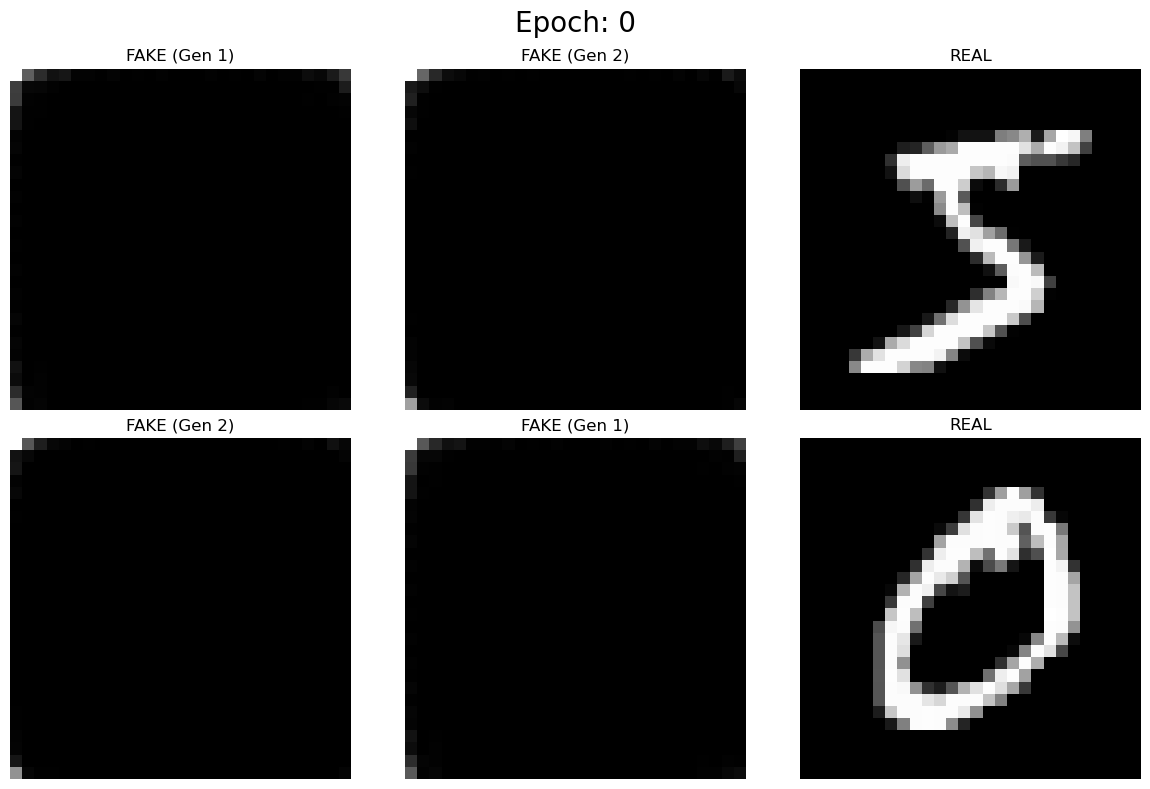

117/117 [==============================] - 16s 83ms/step - g_loss0: 3.1851 - g_loss1: 3.1761 - d_loss: 0.4327
Epoch 2/2
117/117 [==============================] - 9s 75ms/step - g_loss0: 5.1596 - g_loss1: 5.1565 - d_loss: 0.3598


In [21]:
# # Loading previous saved model for resume training
# if os.path.exists(checkpoint_filepath):
#     madgan.load_weights(checkpoint_filepath)
#     print(f"Continue to train model from path: {checkpoint_filepath}")

# train the model
history = madgan.fit(
    dataset,
    epochs=2,
    steps_per_epoch=steps_per_epoch,
    verbose=1,
    callbacks=my_callbacks,
)

In [ ]:
create_gif(image_folder=dir_name, output_gif=dir_name + "/output.gif", duration=250)

In [ ]:
plot_training_history(history)

In [ ]:
((generators[0](random_latent_vectors[0]) * 127.5 + 127.5) / 127.5) * 255